In [172]:
import scanpy as sc
import decoupler as dc
import numpy as np

In [173]:
import anndata as ad

In [213]:
import os
import scanpy as sc
from tqdm import tqdm

folder_path = '/Users/koush/Downloads/GSE215121_RAW/'
h5_files = [f for f in os.listdir(folder_path) if f.endswith('.h5')]

adatas = []
b = 0
for file in tqdm(h5_files):
    adata = sc.read_10x_h5(os.path.join(folder_path, file))
    adata.var_names_make_unique()
    adata.obs['batch'] = b
    adatas.append(adata)
    b += 1

100%|██████████| 11/11 [00:07<00:00,  1.44it/s]


In [214]:
adata = ad.concat(adatas)

In [215]:
import scanpy.external as sce

In [216]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=10)
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

In [217]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.layers['log_norm'] = adata.X.copy()
sc.pp.pca(adata)

In [218]:
sc.pp.highly_variable_genes(adata, n_top_genes=3000, subset=True)

In [219]:
adata

AnnData object with n_obs × n_vars = 25857 × 3000
    obs: 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca', 'hvg'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'log_norm'

In [223]:
import seaborn as sns

<Axes: xlabel='total_counts', ylabel='Density'>

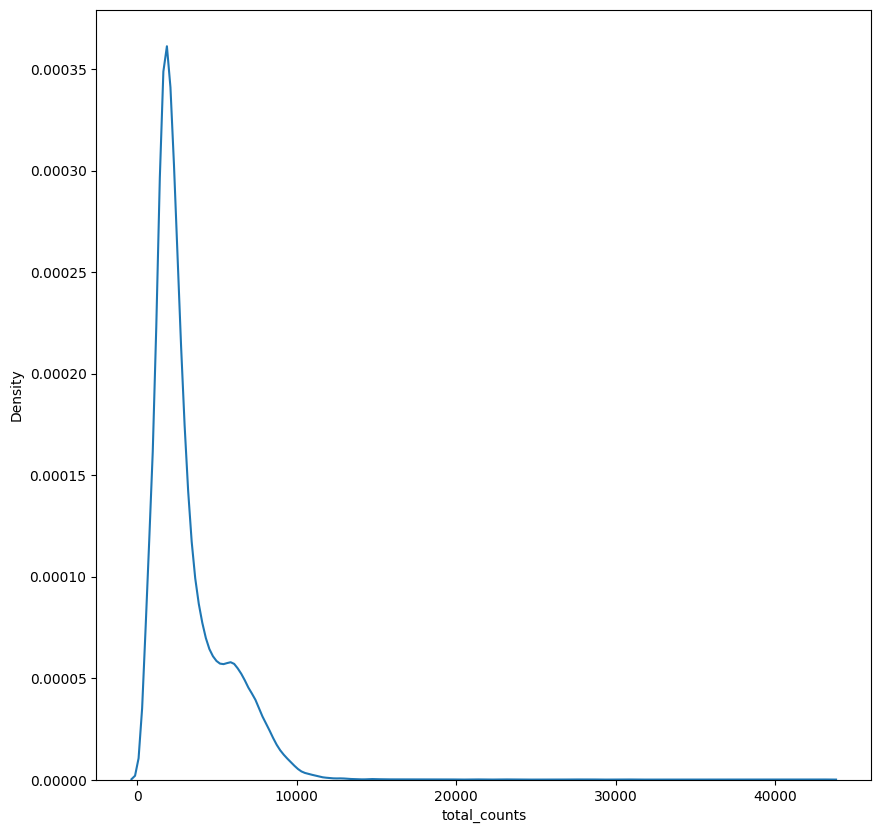

In [224]:
sns.kdeplot(adata.obs['total_counts'])

In [190]:
adata.obs['batch'] = adata.obs['batch'].astype('category')

In [191]:
adata.obs[['batch']].describe()

,batch
count,37964
unique,11
top,10
freq,9564


In [192]:
%%time

sce.pp.harmony_integrate(adata, 'batch')

2024-10-06 13:01:08,923 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2024-10-06 13:13:06,702 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2024-10-06 13:13:06,924 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2024-10-06 13:13:17,817 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2024-10-06 13:13:28,216 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2024-10-06 13:13:37,060 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2024-10-06 13:13:46,321 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2024-10-06 13:13:55,067 - harmonypy - INFO - Converged after 5 iterations
INFO:harmonypy:Converged after 5 iterations


CPU times: user 1h 59min 5s, sys: 1min 44s, total: 2h 50s
Wall time: 12min 46s


In [193]:
adata

AnnData object with n_obs × n_vars = 37964 × 3000
    obs: 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca', 'hvg'
    obsm: 'X_pca', 'X_pca_harmony'
    varm: 'PCs'
    layers: 'log_norm'

In [194]:
import celltypist
from celltypist import models

In [195]:
models.download_models(force_update = False)

In [196]:
# models.models_description()

In [197]:
model = models.Model.load(model = 'Immune_All_Low.pkl')

In [198]:
# model.cell_types

In [208]:
adata.obsm

AxisArrays with keys: X_pca, X_pca_harmony

In [211]:
adata[adata.obs.total_counts < 10000]

View of AnnData object with n_obs × n_vars = 28588 × 3000
    obs: 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca', 'hvg', 'neighbors'
    obsm: 'X_pca', 'X_pca_harmony'
    varm: 'PCs'
    layers: 'log_norm'
    obsp: 'connectivities', 'distances'

In [ ]:
adata.to_df

In [229]:
adata.to_df().sum().sort_values(ascending=False)[:10]

MALAT1      152562.656250
B2M         119456.140625
RPS27       103123.265625
TMSB4X       98852.195312
FTH1         92851.984375
ACTB         88349.226562
RPL21        83290.726562
FTL          82563.312500
RPL13A       81067.828125
HSP90AA1     79871.375000
dtype: float32

In [212]:
%%time 

predictions = celltypist.annotate(
    adata, 
    model = 'Immune_All_Low.pkl',
    majority_voting = True,
)

KeyboardInterrupt: 

In [104]:
predictions

CellTypist prediction result for 3347 query cells
    predicted_labels: data frame with 3 columns ('predicted_labels', 'over_clustering', 'majority_voting')
    decision_matrix: data frame with 3347 query cells and 98 cell types
    probability_matrix: data frame with 3347 query cells and 98 cell types
    adata: AnnData object referred

In [105]:
adata

AnnData object with n_obs × n_vars = 3347 × 20974
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'paga', 'leiden_sizes', 'draw_graph', 'over_clustering'
    obsm: 'X_pca', 'X_umap', 'X_draw_graph_fr'
    varm: 'PCs'
    layers: 'log_norm'
    obsp: 'distances', 'connectivities'

In [106]:
predictions.predicted_labels

,predicted_labels,over_clustering,majority_voting
AAACCCAGTACAGCGA-1,Double-negative thymocytes,20,Early erythroid
AAACGAAAGATGAACT-1,Alveolar macrophages,20,Early erythroid
AAACGAACACGTAACT-1,Fibroblasts,42,Fibroblasts
AAACGAAGTTGATCGT-1,Tcm/Naive helper T cells,31,Tcm/Naive helper T cells
AAACGCTCAATCTAGC-1,Early erythroid,17,Alveolar macrophages
...,...,...,...
TTTGTTGGTCTCGGGT-1,Plasma cells,50,Plasma cells
TTTGTTGGTGAGTTTC-1,Fibroblasts,8,Fibroblasts
TTTGTTGTCCAGCTCT-1,Tem/Trm cytotoxic T cells,42,Fibroblasts
TTTGTTGTCCTAAGTG-1,CD16- NK cells,12,Tcm/Naive helper T cells


In [107]:
adata_annot = predictions.to_adata()

In [108]:
sc.tl.umap(adata_annot)

In [109]:
adata_annot

AnnData object with n_obs × n_vars = 3347 × 20974
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'paga', 'leiden_sizes', 'draw_graph', 'over_clustering'
    obsm: 'X_pca', 'X_umap', 'X_draw_graph_fr'
    varm: 'PCs'
    layers: 'log_norm'
    obsp: 'distances', 'connectivities'

In [110]:
import matplotlib.pyplot as plt

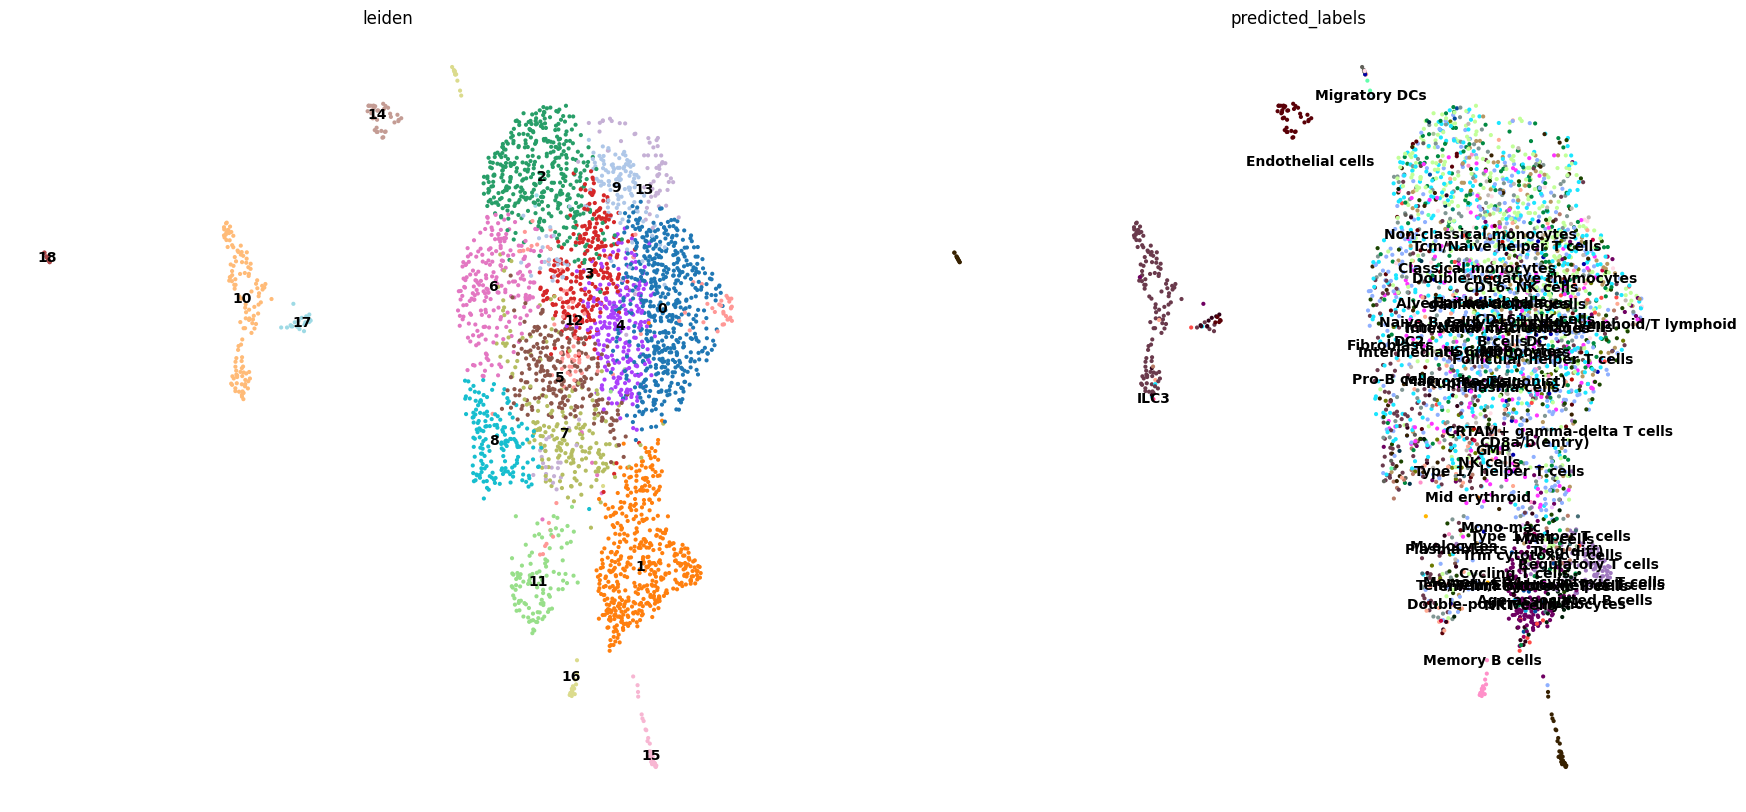

In [111]:
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['figure.dpi'] = 100
sc.pl.umap(
    adata_annot, 
    color = ['leiden', 'predicted_labels'], 
    legend_loc = 'on data', frameon = False)

In [112]:
adata_annot.obs.predicted_labels.value_counts()


predicted_labels
Alveolar macrophages             447
Early erythroid                  446
Tcm/Naive helper T cells         386
Fibroblasts                      292
Epithelial cells                 213
CD16- NK cells                   202
Tem/Trm cytotoxic T cells        162
B cells                          152
Double-negative thymocytes       139
Follicular helper T cells        119
Regulatory T cells                99
Plasma cells                      94
Endothelial cells                 78
Macrophages                       59
NK cells                          49
Tem/Effector helper T cells       47
Tcm/Naive cytotoxic T cells       38
Kupffer cells                     37
Type 17 helper T cells            36
DC                                33
Classical monocytes               31
Memory B cells                    31
Intermediate macrophages          31
CD16+ NK cells                    24
Type 1 helper T cells             14
Tem/Temra cytotoxic T cells       11
Trm cytotoxic T cells